In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
from shapely.ops import linemerge
from shapely import set_precision
import os
import sys
import csv
import json
import logging
import shutil
import utm

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine, correct_geoms, fix_overaps

In [4]:
log = logging.getLogger('papermill')
logging.basicConfig(level='INFO', format="%(message)s")

## Files and storage paths

In [5]:
# Region of interest
reg = 1

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir = os.path.join(data_dir, 'l4_rgi7b0')

# RGI topo dir
topo_dir = os.path.join(data_dir, 'l5_rgitopo/rgi7_tables/output_vardx')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l5_rgi7b1'))
output_dir_zip = mkdir(os.path.join(data_dir, 'l5_rgi7b1_zip'))

In [6]:
# Parameters
reg = 6


In [7]:
reg_str = f'{reg:02d}'

In [8]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)
reg_file = reg_file.loc[reg_file.o1region == f'{reg:02d}'].iloc[0]

input_dir_reg = f'{input_dir}/RGI2000-v7.0-G-{reg_file.long_code}/'
output_dir_reg = mkdir(f'{output_dir}/RGI2000-v7.0-G-{reg_file.long_code}/', reset=True)

### Copy directory

Many things are unchanged:

In [9]:
from distutils.dir_util import copy_tree
copy_tree(input_dir_reg, output_dir_reg)

['../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland.prj',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland.cpg',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland-submission_info_metadata.json',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland-attributes.csv',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland-submission_info.csv',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland.shx',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland-attributes_metadata.json',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland.shp',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/RGI2000-v7.0-G-06_iceland.dbf',
 '../../../../rgi7_data/l5_rgi7b1/RGI2000-v7.0-G-06_iceland/README.md',
 '../../../../rgi7_data/l5

### Load the shp data to overwrite

In [10]:
# Read files
rgi_reg_df = gpd.read_file(f'{input_dir_reg}/RGI2000-v7.0-G-{reg_file.long_code}.shp')

## Load the hypso data and choose 

In [11]:
min_range = 5

In [12]:
# Take COPDEM30 for a start
source = 'COPDEM30'
fp = f'{topo_dir}/hypsometry_rgi{reg_str}_{source}.csv'
hdf = pd.read_csv(fp, index_col=0)

ids = np.where(hdf.columns.values == 'dem_source')[0][0]
attr_cols = list(hdf.columns[0:ids+1])
hypso_cols = list(hdf.columns[ids+1:])

hdf_stats = hdf[attr_cols].copy()
hdf_hypso = hdf[hypso_cols]

valid = (hdf_stats.grid_dx <= 60) & (hdf_stats.valid_dem_perc > 0.99)
valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > min_range)
output_stats = hdf_stats.loc[valid].copy()
output_hypso = hdf_hypso.loc[valid].copy()

In [13]:
# Continue with COPDEM90
source = 'COPDEM90'
fp = f'{topo_dir}/hypsometry_rgi{reg_str}_{source}.csv'

hdf = pd.read_csv(fp, index_col=0)

ids = np.where(hdf.columns.values == 'dem_source')[0][0]
attr_cols = list(hdf.columns[0:ids+1])
hypso_cols = list(hdf.columns[ids+1:])

hdf_stats = hdf[attr_cols].copy()
hdf_hypso = hdf[hypso_cols]

valid = (~ hdf_stats.index.isin(output_stats.index)) & (hdf_stats.valid_dem_perc > 0.99) 
valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > min_range)
output_stats = pd.concat([output_stats, hdf_stats.loc[valid].copy()]).sort_index()
output_hypso = pd.concat([output_hypso, hdf_hypso.loc[valid].copy()]).sort_index()

still_no_good = rgi_reg_df.loc[~ rgi_reg_df.rgi_id.isin(output_stats.index)]
print(f'{reg_str}: After COPDEM, {len(still_no_good)} left bad.')

06: After COPDEM, 0 left bad.


In [14]:
if len(still_no_good) > 0:
    # We have to work
    for alt_range in [min_range, 1]:
        for source in ['NASADEM', 'RAMP', 'GIMP', 'DEM3', 'ASTER', 'TANDEM']:

            fp = f'{topo_dir}/hypsometry_rgi{reg_str}_{source}.csv'
            hdf = pd.read_csv(fp, index_col=0)
            if 'valid_dem_perc' not in hdf:
                continue

            ids = np.where(hdf.columns.values == 'dem_source')[0][0]
            attr_cols = list(hdf.columns[0:ids+1])
            hypso_cols = list(hdf.columns[ids+1:])

            hdf = hdf.loc[still_no_good.rgi_id]
            hdf_stats = hdf[attr_cols].copy()
            hdf_hypso = hdf[hypso_cols]

            valid = (~ hdf_stats.index.isin(output_stats.index)) & (hdf_stats.valid_dem_perc > 0.99) 
            valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > alt_range)
            if len(hdf_stats.loc[valid].copy()) == 0:
                continue
            print(f'{reg}: {source} and minrange {alt_range} can take over for {len(hdf_stats.loc[valid].copy())}')
            output_stats = pd.concat([output_stats, hdf_stats.loc[valid].copy()]).sort_index()
            output_hypso = pd.concat([output_hypso, hdf_hypso.loc[valid].copy()]).sort_index()
            still_no_good = rgi_reg_df.loc[~ rgi_reg_df.rgi_id.isin(output_stats.index)]

            print(f'{reg}: After {source} and minrange {alt_range}, {len(still_no_good)} left bad.')
            if len(still_no_good) == 0:
                break
        if len(still_no_good) == 0:
            break

### Clean up 

In [15]:
output_stats = output_stats.sort_index()

In [16]:
assert len(output_stats) == len(rgi_reg_df) 
assert np.alltrue(output_stats.index == rgi_reg_df.rgi_id)

In [17]:
assert np.alltrue(np.isfinite(output_stats.aspect_deg))
assert np.alltrue(np.isfinite(output_stats.zmean_m))
assert np.alltrue(np.isfinite(output_stats.terminus_lon))

In [18]:
convert_dic = {
    'termlon':'terminus_lon', 
    'termlat':'terminus_lat',
    'zmin_m':'zmin_m',
    'zmax_m':'zmax_m',
    'zmed_m':'zmed_m',
    'zmean_m':'zmean_m',
    'slope_deg':'slope_deg',
    'aspect_deg':'aspect_deg',
    'aspect_sec':'aspect_sec',
    'dem_source':'dem_source',
    }

In [19]:
for k, v in convert_dic.items():
    rgi_reg_df[k] = output_stats[v].values

In [20]:
assert '' not in rgi_reg_df.dem_source.unique()

In [21]:
output_hypso = output_hypso.sort_index()

assert len(output_hypso) == len(rgi_reg_df) 
assert np.alltrue(output_hypso.index == rgi_reg_df.rgi_id)

In [22]:
output_hypso.columns = [int(c) for c in output_hypso.columns]
output_hypso = output_hypso[sorted(output_hypso.columns)]

In [23]:
output_hypso = output_hypso.fillna(0).astype(int)

In [24]:
assert output_hypso.columns.min() > -100
assert np.allclose(output_hypso.sum(axis=1).unique(), 1000)

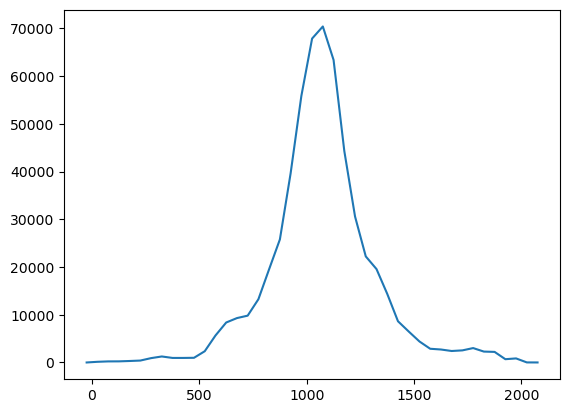

In [25]:
output_hypso.sum().plot();

In [26]:
output_hypso['area_km2'] = rgi_reg_df['area_km2'].values
output_hypso = output_hypso[['area_km2'] + list(output_hypso.columns[:-1])]

## Write out and zip

In [27]:
print('Writing...')
rgi_reg_df.to_file(output_dir_reg + f'/RGI2000-v7.0-G-{reg_file.long_code}.shp')
rgi_reg_df.drop('geometry', axis=1).set_index('rgi_id').to_csv(output_dir_reg + f'/RGI2000-v7.0-G-{reg_file.long_code}-attributes.csv', quoting=csv.QUOTE_NONNUMERIC)
output_hypso.to_csv(output_dir_reg + f'/RGI2000-v7.0-G-{reg_file.long_code}-hypsometry.csv', quoting=csv.QUOTE_NONNUMERIC)

print('Zipping...')
shutil.make_archive(f'{output_dir_zip}/RGI2000-v7.0-G-{reg_file.long_code}', 'zip', output_dir_reg)

Writing...


Zipping...


'/home/www/fmaussion/misc/rgi7_data/l5_rgi7b1_zip/RGI2000-v7.0-G-06_iceland.zip'

## Plots 

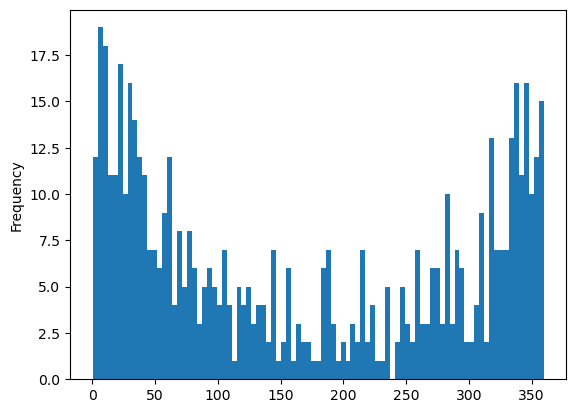

In [28]:
rgi_reg_df.aspect_deg.plot.hist(bins=91);

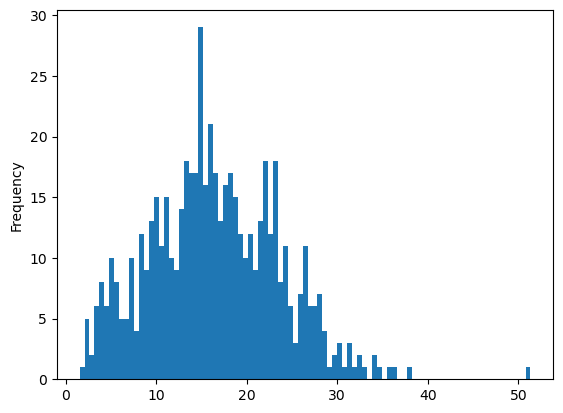

In [29]:
rgi_reg_df.slope_deg.plot.hist(bins=91);